In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170418176/170498071 [00:23<00:00, 10471165.85it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


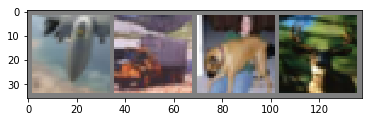

plane truck   dog  deer


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
import torch.nn.functional as F
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().cuda()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.229
[1,  4000] loss: 1.868
[1,  6000] loss: 1.672
[1,  8000] loss: 1.584
[1, 10000] loss: 1.512
[1, 12000] loss: 1.441
[2,  2000] loss: 1.393
[2,  4000] loss: 1.350
[2,  6000] loss: 1.328
[2,  8000] loss: 1.300
[2, 10000] loss: 1.274
[2, 12000] loss: 1.235
Finished Training


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

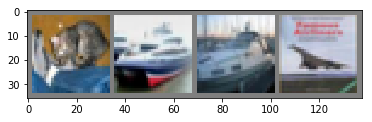

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat plane   car plane


In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 74 %
Accuracy of   car : 72 %
Accuracy of  bird : 38 %
Accuracy of   cat : 20 %
Accuracy of  deer : 52 %
Accuracy of   dog : 45 %
Accuracy of  frog : 75 %
Accuracy of horse : 58 %
Accuracy of  ship : 59 %
Accuracy of truck : 60 %


In [15]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)

In [51]:
print(example_targets.shape)
print(example_data.shape)

torch.Size([4])
torch.Size([4, 3, 32, 32])


In [33]:
grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

In [42]:
x = example_data[0,:,:,:].unsqueeze_(0).requires_grad_(True)
print(x.shape)

y = example_targets[0]

torch.Size([1, 3, 32, 32])


In [43]:
y_hat.unsqueeze_(0).unsqueeze_(0).unsqueeze_(0)
y_hat.shape

torch.Size([1, 1, 1, 10])

In [45]:
y_hat.requires_grad

True

In [48]:
# d = torch.autograd.grad(y_hat, x)[0]

In [46]:
y_hat = net(x)
print(y_hat)
x.register_hook(save_grad('x'))

y_hat.backward(torch.randn(1, 10))

tensor([[-0.4414, -2.7209,  1.0277,  2.3904, -0.0164,  1.1651,  2.0466, -1.4191,
         -0.7392, -2.3005]], grad_fn=<AddmmBackward>)


In [55]:
a = torch.autograd.grad(grads['x'].sum(), x)[0]

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [53]:
d = torch.autograd.grad(y_hat, x)[0]

RuntimeError: grad can be implicitly created only for scalar outputs